In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
%%capture
!conda install -y plotly-orca -c plotly

In [3]:
import os
from base64 import b64encode

import numpy as np
import pandas as pd
from dash import Dash, dcc, html, Input, Output
import plotly.graph_objects as go
from plotly.subplots import  make_subplots
from IPython.display import display, SVG

Define the directories containing (i) the processed data and (ii) the processed results.

In [4]:
modelling_data_dir = '../analysis/modelling'

In [36]:
# Obtain data and format
data = pd.read_csv(os.path.join(modelling_data_dir, 'all_modelling_results.tsv.xz'), sep='\t')
data_counts = pd.read_csv(os.path.join(modelling_data_dir, 'all_modelling_counts.tsv.xz'), sep='\t')
data_counts['datapoints_mutant_percentage'] = data_counts.num_datapoints_mutants / data_counts.num_datapoints_total * 100
data_counts['datapoints_WT_percentage'] = 100 - data_counts.datapoints_mutant_percentage
data_counts['minority_percentage'] = data_counts[['datapoints_mutant_percentage', 'datapoints_WT_percentage']].min(axis=1)
# Add data counts and minority percentage
data_counts = data_counts.drop(columns='datapoints_mutant_percentage')
subplot1_data = (data[(data.crossval == 'random') & (data.folds == 'Mean') & (data.subset == 'complete') & data.contains_mutants]
                 .drop(columns=[col for col in data.columns if  col not in ['Pearson r', 'modeltype', 'accession']]))
subplot1_data = (subplot1_data.merge(data_counts, on='accession')
                 .drop(columns=['accession']))

In [52]:
subplot2_data = (pd.concat([data[(data.crossval == 'random') & (data.folds == 'Mean') & (data.subset == 'complete') & (data.modeltype == 'QSAR') & data.contains_mutants],
                            data[(data.crossval == 'random') & (data.folds == 'Mean') & (data.subset == 'complete') & (data.modeltype == 'QSAR') & ~data.contains_mutants]])
                 .drop(columns=[col for col in data.columns if col not in ['Pearson r', 'accession', 'contains_mutants']]))
subplot2_data = (subplot2_data.merge(data_counts, on='accession')
                 .drop(columns=['accession']))

In [38]:
subplot3_data = (pd.concat([data[(data.crossval == 'random') & (data.folds == 'Mean') & (data.subset == 'common') & (data.modeltype == 'PCM') & ~data.contains_mutants],
                            data[(data.crossval == 'random') & (data.folds == 'Mean') & (data.subset == 'common') & (data.modeltype == 'QSAR') & ~data.contains_mutants]])
                 .drop(columns=[col for col in data.columns if col not in ['Pearson r', 'accession', 'modeltype']]))
subplot3_data = (subplot3_data.merge(data_counts, on='accession')
                 .drop(columns=['accession']))

In [39]:
# Obtain 33rd and 66th percentiles
num_33_percentile = round(pd.concat([subplot1_data.num_datapoints_total, subplot2_data.num_datapoints_total, subplot3_data.num_datapoints_total]).quantile(1/3), 0)
num_66_percentile = round(pd.concat([subplot1_data.num_datapoints_total, subplot2_data.num_datapoints_total, subplot3_data.num_datapoints_total]).quantile(2/3), 0)
ratio_33_percentile = round(pd.concat([subplot1_data.minority_percentage, subplot2_data.minority_percentage, subplot3_data.minority_percentage]).quantile(1/3), 0)
ratio_66_percentile = round(pd.concat([subplot1_data.minority_percentage, subplot2_data.minority_percentage, subplot3_data.minority_percentage]).quantile(2/3), 0)

In [58]:
app = Dash(__name__)

app.layout = html.Div([
                       dcc.Graph(id="heatmap-graph"),
                       html.P("#datapoints:"),
                       dcc.RangeSlider(
                           id='heatmap-x-range-slider',
                           min=subplot1_data.num_datapoints_total.min(),
                           max=subplot1_data.num_datapoints_total.max(),
                           step=1000,
                           value=[subplot1_data.num_datapoints_total.min(), num_33_percentile, num_66_percentile, subplot1_data.num_datapoints_total.max()]
                           ),
                       html.P("balance ratio:"),
                       dcc.RangeSlider(
                            id='heatmap-y-range-slider',
                            min=0, max=50, step=1,
                           value=[0, ratio_33_percentile, ratio_66_percentile, 50]
                            ),
                       ])


@app.callback(
    Output("heatmap-graph", "figure"),
    [Input("heatmap-x-range-slider", "value"),
     Input("heatmap-y-range-slider", "value")])
def update_bar_chart(slider_x, slider_y):
    # Obtain data
    global subplot1_data, subplot2_data, subplot3_data
    subplot_data1 = subplot1_data.copy()
    subplot_data2 = subplot2_data.copy()
    subplot_data3 = subplot3_data.copy()
    # Slider values
    min_x, low_x, high_x, max_x = slider_x
    min_y, low_y, high_y, max_y = slider_y
    # Obtain categories
    intervals_num_datapoints = [(min_x - 0.1, low_x),
                            (low_x, high_x),
                            (high_x, max_x)]
    intervals_ratio = [(min_y - 0.1, low_y),
                       (low_y, high_y),
                       (high_y, max_y)]
    num_intervals = pd.IntervalIndex.from_tuples(intervals_num_datapoints)
    ratio_intervals = pd.IntervalIndex.from_tuples(intervals_ratio)
    # Put data in bins
    subplot_data1['num_bins'] = pd.cut(subplot_data1.num_datapoints_total.values, num_intervals)
    subplot_data2['num_bins'] = pd.cut(subplot_data2.num_datapoints_total.values, num_intervals)
    subplot_data3['num_bins'] = pd.cut(subplot_data3.num_datapoints_total.values, num_intervals)
    subplot_data1['ratio_bins'] = pd.cut(subplot_data1.minority_percentage.values, ratio_intervals)
    subplot_data2['ratio_bins'] = pd.cut(subplot_data2.minority_percentage.values, ratio_intervals)
    subplot_data3['ratio_bins'] = pd.cut(subplot_data3.minority_percentage.values, ratio_intervals)
    # Rename intervals
    subplot_data1['num_bins'] = subplot_data1['num_bins'].astype(str)#.cat.rename_categories(dict(zip(num_intervals, ['low', 'medium', 'high'])))
    subplot_data2['num_bins'] = subplot_data2['num_bins'].astype(str)#.cat.rename_categories(dict(zip(num_intervals, ['low', 'medium', 'high'])))
    subplot_data3['num_bins'] = subplot_data3['num_bins'].astype(str)#.cat.rename_categories(dict(zip(num_intervals, ['low', 'medium', 'high'])))
    subplot_data1['ratio_bins'] = subplot_data1['ratio_bins'].astype(str)#.cat.rename_categories(dict(zip(ratio_intervals, ['low', 'medium', 'high'])))
    subplot_data2['ratio_bins'] = subplot_data2['ratio_bins'].astype(str)#.cat.rename_categories(dict(zip(ratio_intervals, ['low', 'medium', 'high'])))
    subplot_data3['ratio_bins'] = subplot_data3['ratio_bins'].astype(str)#.cat.rename_categories(dict(zip(ratio_intervals, ['low', 'medium', 'high'])))
    # Clean up columns
    subplot_data1 = subplot_data1.drop(columns=['num_datapoints_total', 'minority_percentage'])
    subplot_data2 = subplot_data2.drop(columns=['num_datapoints_total', 'minority_percentage'])
    subplot_data3 = subplot_data3.drop(columns=['num_datapoints_total', 'minority_percentage'])
    
    # Remove nan bins
    subplot_data1 = subplot_data1[subplot_data1.num_bins != 'nan']
    subplot_data2 = subplot_data2[subplot_data2.num_bins != 'nan']
    subplot_data3 = subplot_data3[subplot_data3.num_bins != 'nan']
    
    # Group by, pivot and obtain difference
    subplot_data1 = subplot_data1.groupby(['modeltype', 'num_bins', 'ratio_bins']).agg('mean').reset_index()
    subplot_data1 = subplot_data1.pivot(columns=['num_bins'], values='Pearson r',
                                      index=['modeltype', 'ratio_bins']).reset_index()
    subplot_data1.iloc[np.where(subplot_data1.modeltype == 'QSAR')[0], 2:] = -subplot_data1.iloc[np.where(subplot_data1.modeltype == 'QSAR')[0], 2:]
    subplot_data1 = subplot_data1.drop(columns='modeltype').groupby('ratio_bins').agg('sum')
    # subplot_data1
    
    subplot_data2 = subplot_data2.groupby(['contains_mutants', 'num_bins', 'ratio_bins']).agg('mean').reset_index()
    subplot_data2 = subplot_data2.pivot(columns=['num_bins'], values='Pearson r',
                                      index=['contains_mutants', 'ratio_bins']).reset_index()
    subplot_data2.iloc[np.where(~subplot_data2.contains_mutants)[0], 2:] = -subplot_data2.iloc[np.where(~subplot_data2.contains_mutants)[0], 2:]
    subplot_data2 = subplot_data2.drop(columns='contains_mutants').groupby('ratio_bins').agg('sum')
    # subplot_data2
    
    subplot_data3 = subplot_data3.groupby(['modeltype', 'num_bins', 'ratio_bins']).agg('mean').reset_index()
    subplot_data3 = subplot_data3.pivot(columns=['num_bins'], values='Pearson r',
                                      index=['modeltype', 'ratio_bins']).reset_index()
    subplot_data3.iloc[np.where(subplot_data3.modeltype == 'QSAR')[0], 2:] = -subplot_data3.iloc[np.where(subplot_data3.modeltype == 'QSAR')[0], 2:]
    subplot_data3 = subplot_data3.drop(columns='modeltype').groupby('ratio_bins').agg('sum')
    # Melt dataframes 
    subplot_data1 = pd.melt(subplot_data1.reset_index(), id_vars=['ratio_bins']) 
    subplot_data2 = pd.melt(subplot_data2.reset_index(), id_vars=['ratio_bins'])
    subplot_data3 = pd.melt(subplot_data3.reset_index(), id_vars=['ratio_bins'])
    
    # Rename intervals
    subplot_data1['num_bins'] = subplot_data1['num_bins'].replace({str(num_intervals[0]): f'[{intervals_num_datapoints[0][0] + 0.1:.0f}, {intervals_num_datapoints[1][0]:.0f}]'})
    subplot_data1['num_bins'] = subplot_data1['num_bins'].replace({str(num_intervals[1]): f'({intervals_num_datapoints[1][0]:.0f}, {intervals_num_datapoints[1][1]:.0f}]'})
    subplot_data1['num_bins'] = subplot_data1['num_bins'].replace({str(num_intervals[2]): f'({intervals_num_datapoints[2][0]:.0f}, {intervals_num_datapoints[2][1]:.0f}]'})
    subplot_data1['ratio_bins'] = subplot_data1['ratio_bins'].replace({str(ratio_intervals[0]): f'[{intervals_ratio[0][0]:.0f}, {intervals_ratio[0][1]:.0f}]'})
    subplot_data1['ratio_bins'] = subplot_data1['ratio_bins'].replace({str(ratio_intervals[0]): f'({intervals_ratio[1][0]:.0f}, {intervals_ratio[1][1]:.0f}]'})
    subplot_data1['ratio_bins'] = subplot_data1['ratio_bins'].replace({str(ratio_intervals[0]): f'({intervals_ratio[2][0]:.0f}, {intervals_ratio[2][1]:.0f}]'})
    
    subplot_data2['num_bins'] = subplot_data2['num_bins'].replace({str(num_intervals[0]): f'[{intervals_num_datapoints[0][0] + 0.1:.0f}, {intervals_num_datapoints[1][0]:.0f}]'})
    subplot_data2['num_bins'] = subplot_data2['num_bins'].replace({str(num_intervals[1]): f'({intervals_num_datapoints[1][0]:.0f}, {intervals_num_datapoints[1][1]:.0f}]'})
    subplot_data2['num_bins'] = subplot_data2['num_bins'].replace({str(num_intervals[2]): f'({intervals_num_datapoints[2][0]:.0f}, {intervals_num_datapoints[2][1]:.0f}]'})
    subplot_data2['ratio_bins'] = subplot_data2['ratio_bins'].replace({str(ratio_intervals[0]): f'[{intervals_ratio[0][0]:.0f}, {intervals_ratio[0][1]:.0f}]'})
    subplot_data2['ratio_bins'] = subplot_data2['ratio_bins'].replace({str(ratio_intervals[0]): f'({intervals_ratio[1][0]:.0f}, {intervals_ratio[1][1]:.0f}]'})
    subplot_data2['ratio_bins'] = subplot_data2['ratio_bins'].replace({str(ratio_intervals[0]): f'({intervals_ratio[2][0]:.0f}, {intervals_ratio[2][1]:.0f}]'})
    
    subplot_data3['num_bins'] = subplot_data3['num_bins'].replace({str(num_intervals[0]): f'[{intervals_num_datapoints[0][0] + 0.1:.0f}, {intervals_num_datapoints[1][0]:.0f}]'})
    subplot_data3['num_bins'] = subplot_data3['num_bins'].replace({str(num_intervals[1]): f'({intervals_num_datapoints[1][0]:.0f}, {intervals_num_datapoints[1][1]:.0f}]'})
    subplot_data3['num_bins'] = subplot_data3['num_bins'].replace({str(num_intervals[2]): f'({intervals_num_datapoints[2][0]:.0f}, {intervals_num_datapoints[2][1]:.0f}]'})
    subplot_data3['ratio_bins'] = subplot_data3['ratio_bins'].replace({str(ratio_intervals[0]): f'[{intervals_ratio[0][0]:.0f}, {intervals_ratio[0][1]:.0f}]'})
    subplot_data3['ratio_bins'] = subplot_data3['ratio_bins'].replace({str(ratio_intervals[0]): f'({intervals_ratio[1][0]:.0f}, {intervals_ratio[1][1]:.0f}]'})
    subplot_data3['ratio_bins'] = subplot_data3['ratio_bins'].replace({str(ratio_intervals[0]): f'({intervals_ratio[2][0]:.0f}, {intervals_ratio[2][1]:.0f}]'})
    
    # Determine zmax for colorbar
    zmax = max((subplot_data1.value.max(),
                subplot_data2.value.max(),
                subplot_data3.value.max()))
    
    # Figure
    fig = make_subplots(rows=1, cols=3,
                        shared_yaxes=True,
                        subplot_titles=['PCM complete - QSAR complete', 'QSAR complete - QSAR no mutant', 'PCM common - QSAR common'],
                       )
    
    fig.add_trace(go.Heatmap(x=subplot_data1.num_bins, y=subplot_data1.ratio_bins, z=subplot_data1.value, 
                             zmin=0, zmax=zmax,
                             showscale=False,
                             colorscale='RdYlGn',
                             ),
                  row=1, col=1)
    
    fig.add_trace(go.Heatmap(x=subplot_data2.num_bins, y=subplot_data2.ratio_bins, z=subplot_data2.value,
                             zmin=0, zmax=zmax,
                             showscale=False,
                             colorscale='RdYlGn',
                             ),
                  row=1, col=2)
    
    fig.add_trace(go.Heatmap(x=subplot_data3.num_bins, y=subplot_data3.ratio_bins, z=subplot_data3.value,
                             zmin=0, zmax=zmax,
                             colorscale='RdYlGn',
                             colorbar={"title": 'Pearson r'}
                             ),
                  row=1, col=3)
    # Add title
    fig.update_layout({'xaxis': {'categoryarray': [f'[{intervals_num_datapoints[0][0] + 0.1:.0f}, {intervals_num_datapoints[1][0]:.0f}]',
                                                   f'({intervals_num_datapoints[1][0]:.0f}, {intervals_num_datapoints[1][1]:.0f}]',
                                                   f'({intervals_num_datapoints[2][0]:.0f}, {intervals_num_datapoints[2][1]:.0f}]'],
                                 'title': '#compound-target pairs per accession'},
                       'xaxis2': {'categoryarray': [f'[{intervals_num_datapoints[0][0] + 0.1:.0f}, {intervals_num_datapoints[1][0]:.0f}]',
                                                   f'({intervals_num_datapoints[1][0]:.0f}, {intervals_num_datapoints[1][1]:.0f}]',
                                                   f'({intervals_num_datapoints[2][0]:.0f}, {intervals_num_datapoints[2][1]:.0f}]'],
                                 'title': '#compound-target pairs per accession'},
                       'xaxis3': {'categoryarray': [f'[{intervals_num_datapoints[0][0] + 0.1:.0f}, {intervals_num_datapoints[1][0]:.0f}]',
                                                   f'({intervals_num_datapoints[1][0]:.0f}, {intervals_num_datapoints[1][1]:.0f}]',
                                                   f'({intervals_num_datapoints[2][0]:.0f}, {intervals_num_datapoints[2][1]:.0f}]'],
                                 'title': '#compound-target pairs per accession'},
                       'yaxis': {'title': 'Minority class (WT/mutant) %'}
                       })

    fig.update_traces(row=1, col=1, text=subplot_data1.value, texttemplate="%{text:.3f}", hovertemplate=None)
    fig.update_traces(row=1, col=2, text=subplot_data2.value, texttemplate="%{text:.3f}", hovertemplate=None)
    fig.update_traces(row=1, col=3, text=subplot_data3.value, texttemplate="%{text:.3f}", hovertemplate=None)
        
    return fig

if __name__ == '__main__':
    app.run_server(debug=False)

Export heatmaps to SVG 

In [60]:
if not os.path.exists(os.path.join(modelling_data_dir, 'heatmaps')):
    os.makedirs(os.path.join(os.path.join(modelling_data_dir, 'heatmaps')), exist_ok=True)

In [61]:
# Default percentile
update_bar_chart((7, num_33_percentile, num_66_percentile, 20056), (0, ratio_33_percentile, ratio_66_percentile, 50)
                 ).write_image(os.path.join(modelling_data_dir, 'heatmaps/bin_heatmaps_percentiles.svg'), engine='orca')

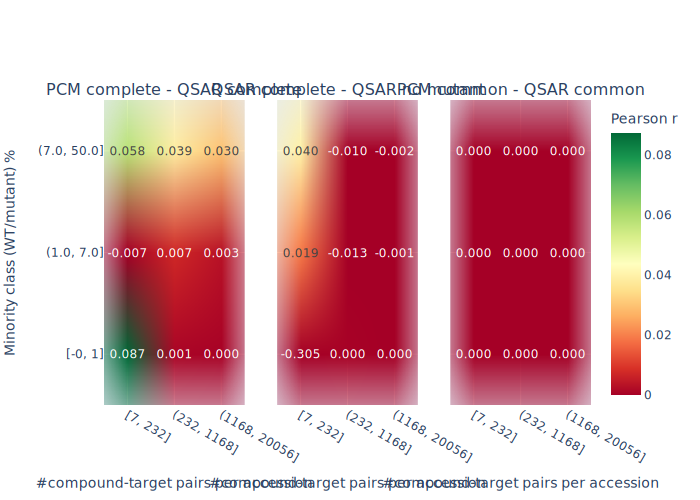

In [62]:
display(SVG(data=os.path.join(modelling_data_dir, 'heatmaps/bin_heatmaps_percentiles.svg')))

In [63]:
#Nums  = [0, 1_000],  (1_000, 10_000],  (10_000, 75_211]
#Ratios= [0, 16.67%], (16,67%, 33.34%], (33.34%, 50.0%]
update_bar_chart((0, 1_000, 10_000, 20056), (0, 15, 30, 50)
                 ).write_image(os.path.join(modelling_data_dir, 'heatmaps/bin_heatmaps_num-1k-10k.svg'), engine='orca')

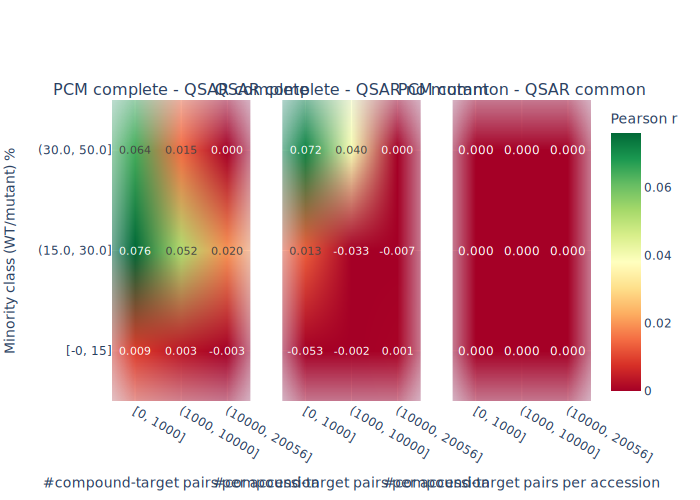

In [64]:
display(SVG(data=os.path.join(modelling_data_dir, 'heatmaps/bin_heatmaps_num-1k-10k.svg')))

In [65]:
#Nums  = [0, 100],    (100, 500],       (500, 1_000]
#Ratios= [0, 16.67%], (16,67%, 33.34%], (33.34%, 50.0%]
update_bar_chart((0, 100, 500, 1000), (0, 15, 30, 50)
                 ).write_image(os.path.join(modelling_data_dir, 'heatmaps/bin_heatmaps_num-1k-10k.svg'), engine='orca')

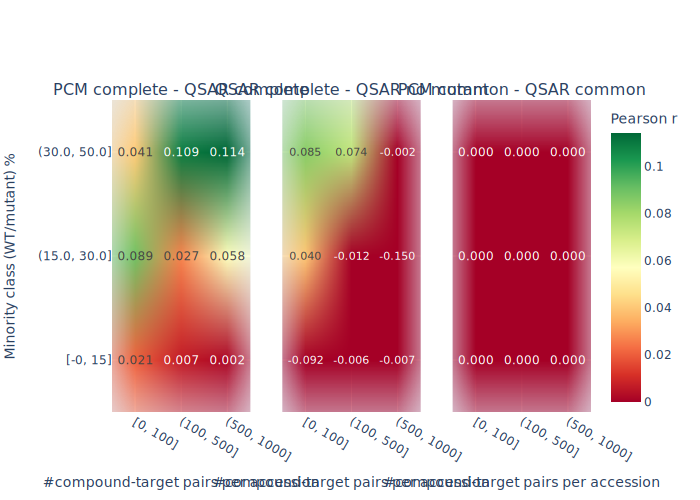

In [66]:
display(SVG(data=os.path.join(modelling_data_dir, 'heatmaps/bin_heatmaps_num-1k-10k.svg')))

In [67]:
#Nums  = [1_000, 2_000],  (2_000, 5_000],  (5_000, 10_000]
#Ratios= [0, 16.67%], (16,67%, 33.34%], (33.34%, 50.0%]
update_bar_chart((1_000, 2_000, 5_000, 10_000), (0, 17, 33, 50)
                 ).write_image(os.path.join(modelling_data_dir, 'heatmaps/bin_heatmaps_num-1k-10k-zoomin.svg'), engine='orca')

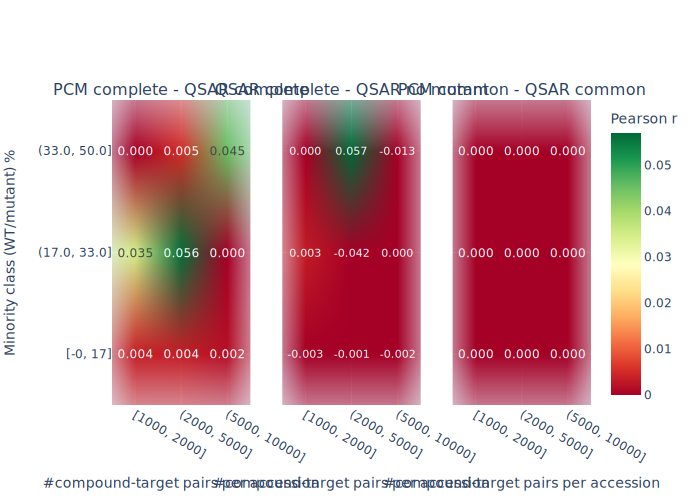

In [68]:
display(SVG(data=os.path.join(modelling_data_dir, 'heatmaps/bin_heatmaps_num-1k-10k-zoomin.svg')))

In [81]:
#Nums  = [10_000, 15_000],  (15_000, 50_000],  (50_000, 75_211]
#Ratios= [0, 16.67%],       (16,67%, 33.34%],  (33.34%, 50.0%]
update_bar_chart((10_000, 14000, 18000, 20056), (0, 17, 33, 50)
                 ).write_image(os.path.join(modelling_data_dir, 'heatmaps/bin_heatmaps_num-10k-max-zoomin.svg'), engine='orca')

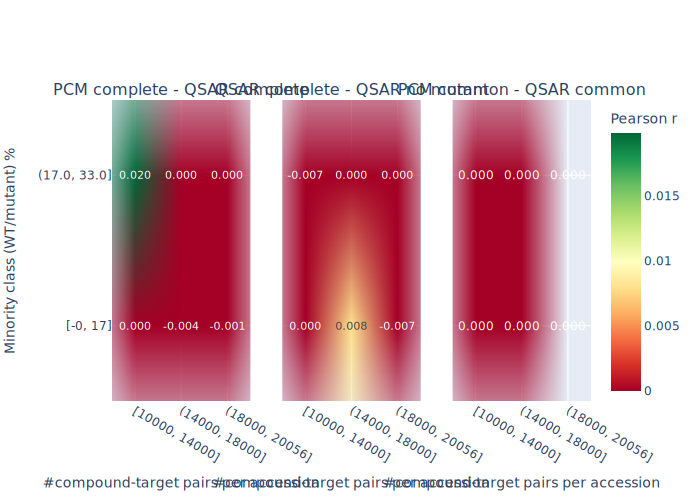

In [82]:
display(SVG(data=os.path.join(modelling_data_dir, 'heatmaps/bin_heatmaps_num-10k-max-zoomin.svg')))